In [1]:
import glob
import os
import pandas as pd

In [2]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import shapely.geometry as sgeom
import matplotlib.colors as mcolors
import matplotlib.cm as mcm
import matplotlib.ticker as mticker

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

%matplotlib inline

In [3]:
ls data

NEH_Evaluators.csv     NEH_Grants1980s.csv    NEH_StateCouncils.csv
NEH_Grants.csv         NEH_Grants1990s.csv    gc.csv
NEH_Grants1960s.csv    NEH_Grants2000s.csv
NEH_Grants1970s.csv    NEH_Grants2010s.csv


In [4]:
dfs = []
for fn in glob.glob('data/NEH_Grants*s.csv'):
    df = pd.read_csv(fn)
    #df['datetime'] = pd.to_datetime(df['BeginGrant'], format='%Y-%m-%dT%H:%M:%S')
    dfs.append(df)

In [5]:
def _plot(yr_state, cmap, norm, cfunc, clabel, extend, title, fmt, filename):
    
    shapename = 'admin_1_states_provinces_lakes_shp'
    states_shp = shpreader.natural_earth(resolution='110m', 
                                         category='cultural', name=shapename)
    states = shpreader.Reader(states_shp)

    
    fig = plt.figure()
    
    ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal())
    ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())
    #ax.set_extent([-150, -66.5, 20, 50], ccrs.Geodetic())
    ax.background_patch.set_visible(False)
    ax.outline_patch.set_visible(False)
    
    for state, geo in zip(states.records(), states.geometries()):
        sn = state.attributes['postal']
        val = yr_state[sn]
        color = cfunc(val)
        ax.add_geometries([geo], ccrs.PlateCarree(), facecolor=color, edgecolor='black')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []
    cb = plt.colorbar(sm, ax=ax, fraction=.035, pad=.0, aspect=15, extend=extend, 
                      anchor=[-5,0], format=fmt)
    #cb.set_ticks(bounds)
    cb.ax.tick_params(labelsize=14)
    cb.set_label(clabel , fontsize=16)
    ax.set_title(title, fontsize=18)
    plt.show()
    fig.savefig(filename, bbox_inches="tight")

In [6]:
def plot_percent(yr_state, yr):
    cmap = mcm.viridis_r
    norm = mcolors.Normalize(vmin=0, vmax=20)  
    cfunc = lambda val: cmap(norm(((val*1.0)/yr_state.sum())*100))
       
    clabel = "of US Funding"
    extend = "max"
    title = "Outright Award Funding: {}s".format(yr)
    filename = "NEH_percentage_{}s".format(yr)
    fmt = mticker.FormatStrFormatter('%d%%')
    _plot(yr_state, cmap, norm, cfunc, clabel, extend, title, fmt, filename)

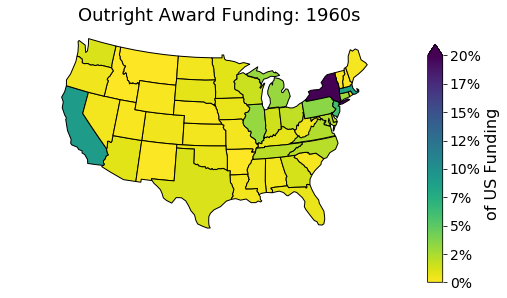

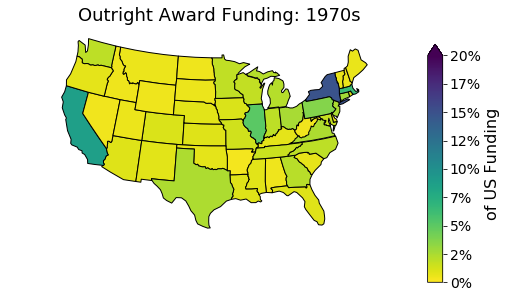

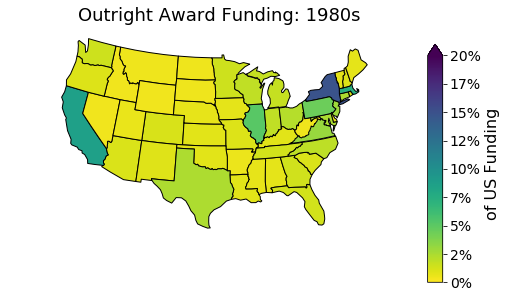

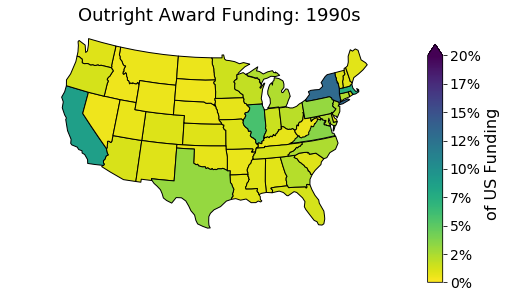

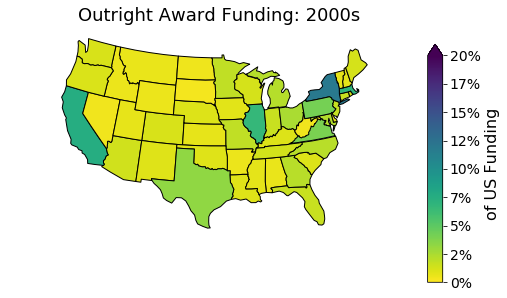

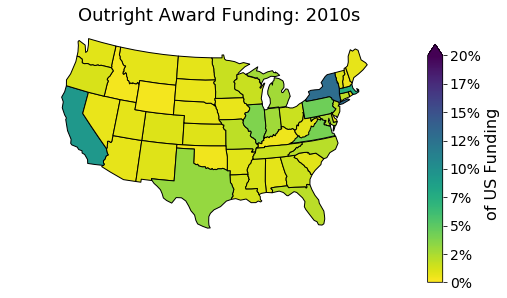

In [7]:
for df, yr in zip(dfs, [1960,1970,1980,1990,2000,2010]):
    yr_state = df.groupby('InstState')['AwardOutright'].sum()
    plot_percent(yr_state, yr)

In [8]:
def plot_total_bounds(yr_state, yr):
    bounds = [1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9]
    cmap = mcm.Blues
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    cfunc = lambda val: cmap(norm(val))
    
    clabel = "Total Awarded Outright ($)"
    extend = "both"
    title = "Outright Award Funding: {}s".format(yr)
    filename = "NEH_total_{}s".format(yr)
    fmt = mticker.FormatStrFormatter('%.2g')
    _plot(yr_state, cmap, norm, cfunc, clabel, extend, title,fmt, filename)
    
    
   

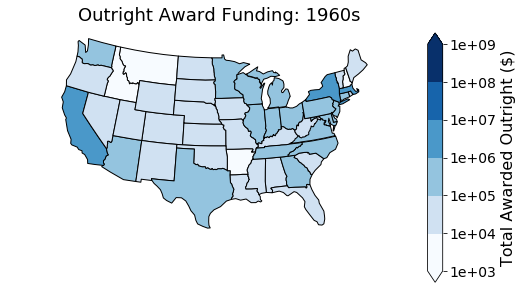

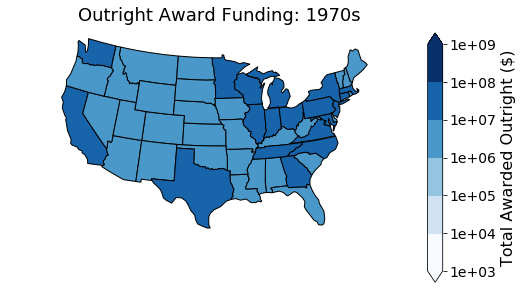

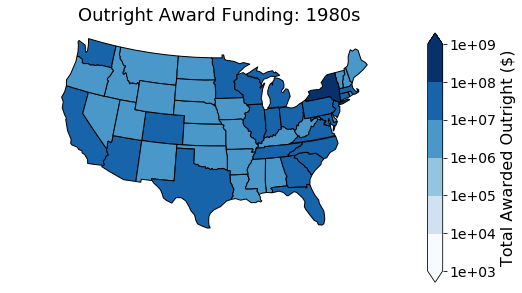

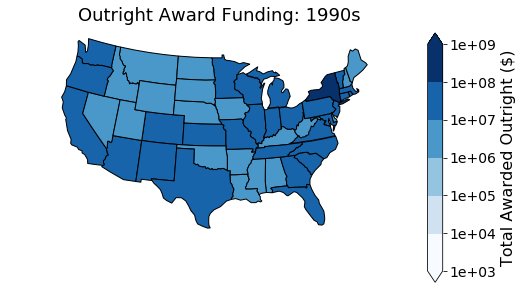

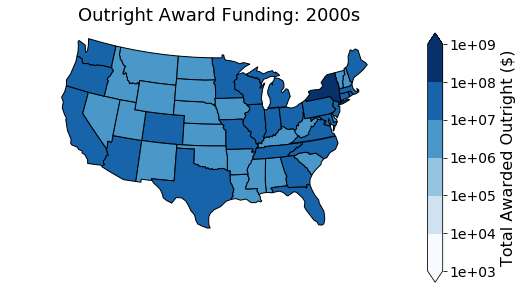

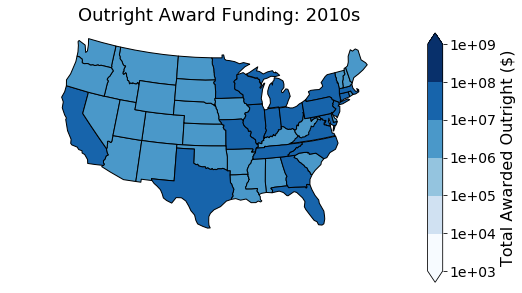

In [9]:
for df, yr in zip(dfs, [1960,1970,1980,1990,2000,2010]):
    yr_state = df.groupby('InstState')['AwardOutright'].sum()
    plot_total_bounds(yr_state, yr)

In [57]:
def plot_total_log(yr_state, yr):
    bounds = [1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9]
    cmap = mcm.viridis_r
    norm = mcolors.LogNorm(vmin=bounds[0], vmax=bounds[-2])
    cfunc = lambda val: cmap(norm(val))
    
    clabel = "Total Awarded Outright ($)"
    extend = "both"
    title = "Outright Award Funding: {}s".format(yr)
    filename = "NEH_log_{}s".format(yr)
    fmt = None
    _plot(yr_state, cmap, norm, cfunc, clabel, extend, title, fmt, filename)

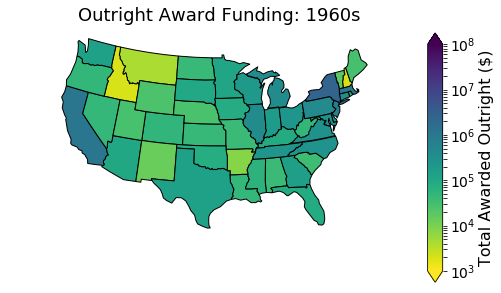

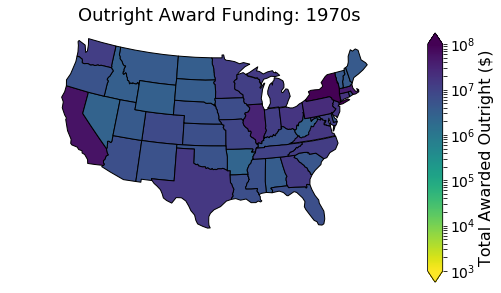

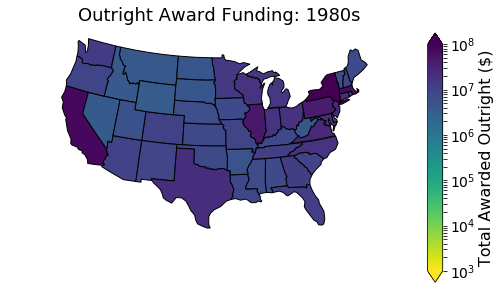

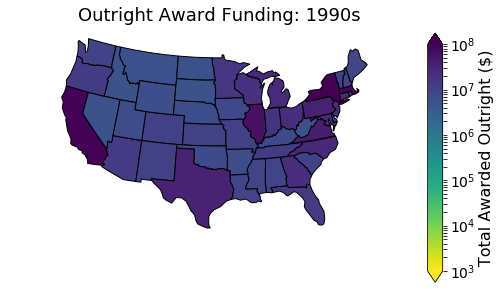

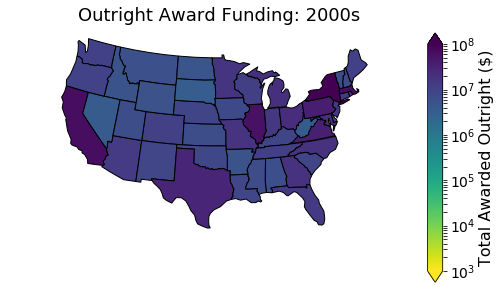

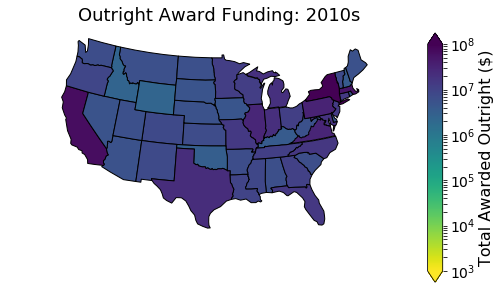

In [58]:
for df, yr in zip(dfs, [1960,1970,1980,1990,2000,2010]):
    yr_state = df.groupby('InstState')['AwardOutright'].sum()
    plot_total_log(yr_state, yr)

In [59]:
import datetime
from pandas_datareader import data as pddata

start = datetime.datetime(1960, 1, 1)
end = datetime.datetime(2016,3, 27)

cpium=pddata.DataReader("CPIAUCSL", "fred", start, end)

In [60]:
inflation = cpium/cpium.ix['2016-03-01']
monthly = inflation.index.strftime("%Y-%m")
monthly_inflation = inflation.reindex(monthly)

In [64]:
def plot_total_adjusted(yr_state, yr):
    bounds = [1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9]
    cmap = mcm.viridis_r
    norm = mcolors.LogNorm(vmin=bounds[0], vmax=bounds[-2])
    cfunc = lambda val: cmap(norm(val))
    
    clabel = "Total Awarded Outright\n($ adjusted for inflation)"
    extend = "both"
    title = "Outright Award Funding: {}s".format(yr)
    filename = "NEH_adjusted_{}s".format(yr)
    fmt = None
    _plot(yr_state, cmap, norm, cfunc, clabel, extend, title, fmt, filename)

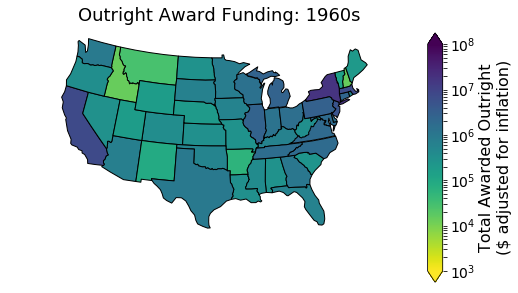

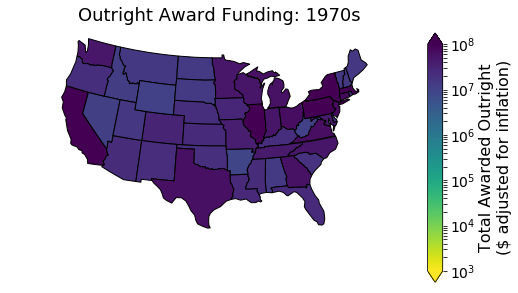

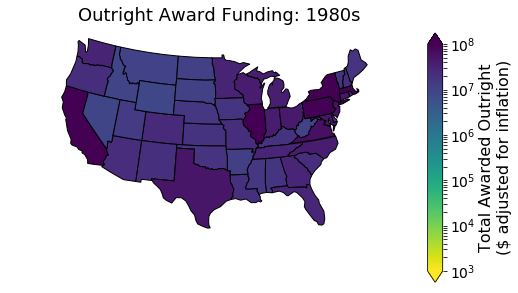

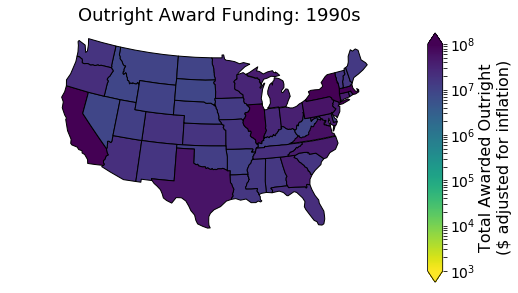

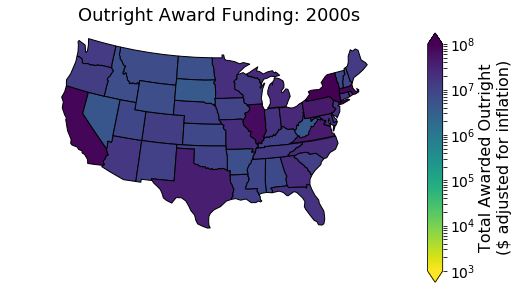

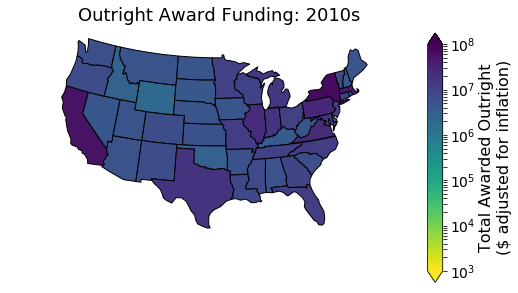

In [65]:
for df, yr in zip(dfs, [1960,1970,1980,1990,2000,2010]):
    
    df['date'] = df['BeginGrant'].str.rpartition("-")[0]
    df['inflation'] = monthly_inflation.loc[df['date']]['CPIAUCSL'].values
    df['AwardOutrightAdjusted'] = df['AwardOutright']/df['inflation']
    yr_state = df.groupby('InstState')['AwardOutrightAdjusted'].sum()
    plot_total_adjusted(yr_state, yr)